# Analyse des sessions

On va s'intéresser dans cette section à l'historique des activités (sessions) des utilisateurs. 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [2]:
users = pd.read_csv('data/train_users_2.csv')
test_users = pd.read_csv('data/test_users.csv')
sessions = pd.read_csv('data/sessions.csv')

users['found_destination'] = users.apply(lambda r: 'DF' if r['country_destination'] != 'NDF' else 'NDF', axis=1)

On a vu, dans l'introduction, qu'on ne dispose pas des sessions de tous les utilisateurs. De ce fait, on va sélectioner les utilisateurs qui ont une session avant d'équilibrer les classes (DF/NDF).

In [3]:
# Extract user ids who have sessions
base_user_ids = sessions['user_id'].unique()
base_user_ids = base_user_ids.tolist()
base_user_ids.remove(np.nan)

# Remove user ids who are from the test set
test_user_ids = test_users['id'].values
base_user_ids = list(set(base_user_ids) - set(test_user_ids))

# Select sessions with the remaining ids
users_by_ids = users.set_index('id')
session_users = users_by_ids.loc[base_user_ids]

# Balance DF and NDF labels
session_users_ndf = session_users[session_users['found_destination'] == 'NDF'].head(20000)
session_users_df = session_users[session_users['found_destination'] == 'DF'].head(20000)
session_users = pd.concat([session_users_ndf, session_users_df])

sessions = sessions[sessions['user_id'].isin(session_users.index)]
print(f'sessions.shape : {sessions.shape}')
sessions.head()

sessions.shape : (3098239, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


On a 20000 + 20000 utilisateurs DF et NDF.

In [4]:
sessions['found_destination'] = sessions.apply(lambda r: session_users.loc[r['user_id'], 'found_destination'], axis=1)

Affichons le temps que les utilisateurs ont passé sur le site (somme du temps écoulé par activités).

Median NDF : 194.76472222222222 h
Median DF : 328.4058333333333 h


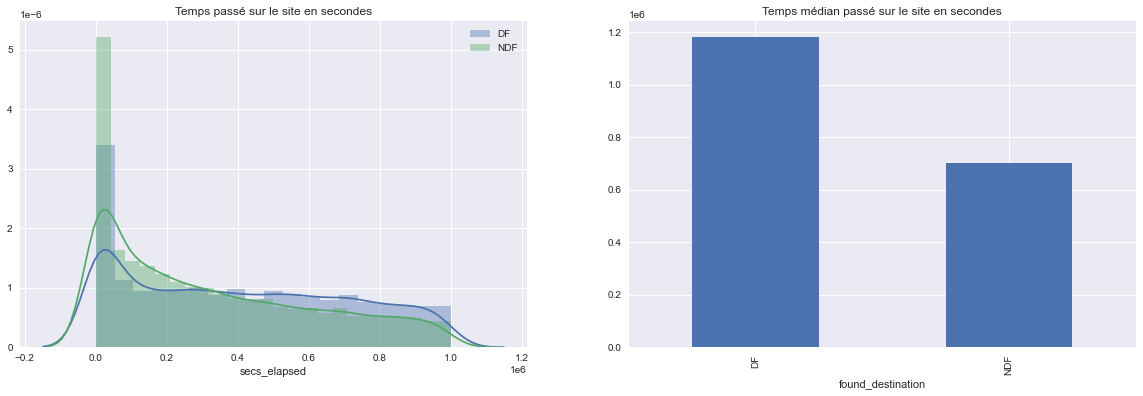

In [22]:
time_elapsed = sessions.groupby(['user_id', 'found_destination'])['secs_elapsed'].sum()
f = plt.figure(figsize=(20, 6))
f.add_subplot(1, 2, 1)
sns.distplot(time_elapsed[time_elapsed < 0.1e7].loc[:,'DF'], label='DF')
sns.distplot(time_elapsed[time_elapsed < 0.1e7].loc[:,'NDF'], label='NDF')
plt.title("Temps passé sur le site en secondes")
plt.legend()
print(f'Median NDF : {time_elapsed.loc[:, "NDF"].median() / (60**2)} h')
print(f'Median DF : {time_elapsed.loc[:, "DF"].median() / (60**2)} h')

f.add_subplot(1, 2, 2)
time_elapsed.groupby('found_destination').median().plot(kind='bar')
_ = plt.title("Temps médian passé sur le site en secondes")

Les DF passent beaucoup plus de temps sur le site que les NDF, probablement car ils font l'effort de renseigner leur profil, passer du temps sur les différentes annonces, écrire aux hôtes pour poser des questions, etc. Il est possible qu'une partie des NDF ne font que regarder, mais ce ne sont que des hypothèses. 

On va récupérer les actions les plus présentes chez les DF puis chez les NDF.

In [6]:
# Actions that are common among DF / NDF
actions = sessions.groupby(['user_id', 'found_destination']).agg({'action': pd.Series.tolist}).reset_index()
actions['number_actions'] = actions.apply(lambda r: r['action'].__len__(), axis=1)
actions.head()

,user_id,found_destination,action,number_actions
0,001wyh0pz8,NDF,"[search, search, search, show, social_connecti...",90
1,002qnbzfs5,DF,"[social_connections, payment_methods, create, ...",789
2,0035hobuyj,DF,"[lookup, search_results, lookup, search_result...",489
3,003iamz20l,NDF,"[active, search, search, search, social_connec...",163
4,005jc3nbmb,NDF,"[recommended_listings, ask_question, nan, dash...",26


In [7]:
def count_actions(action, booked):
    actions['tmp'] = actions.apply(lambda r: 1 if action in r['action'] else 0, axis=1)
    res = actions[actions['found_destination'] == booked]['tmp'].sum()
    actions.drop('tmp', axis=1)
    return res

# Actions that are the most common among DF
action_stats_df = pd.DataFrame()
action_stats_df['action'] = sessions.action.unique()
action_stats_df['count'] = action_stats_df.apply(lambda r: count_actions(r['action'], 'DF'), axis=1)

# Actions that are the most common among NDF
action_stats_ndf = pd.DataFrame()
action_stats_ndf['action'] = sessions.action.unique()
action_stats_ndf['count'] = action_stats_ndf.apply(lambda r: count_actions(r['action'], 'NDF'), axis=1)

# Combine DF and NDF
action_stats = pd.DataFrame()
action_stats['action'] = sessions['action'].unique()
action_stats['count_df'] = action_stats_df['count'].values
action_stats['count_ndf'] = action_stats_ndf['count'].values
action_stats['diff'] = (action_stats['count_df'] - action_stats['count_ndf']) / (action_stats['count_df'] + action_stats['count_ndf'])

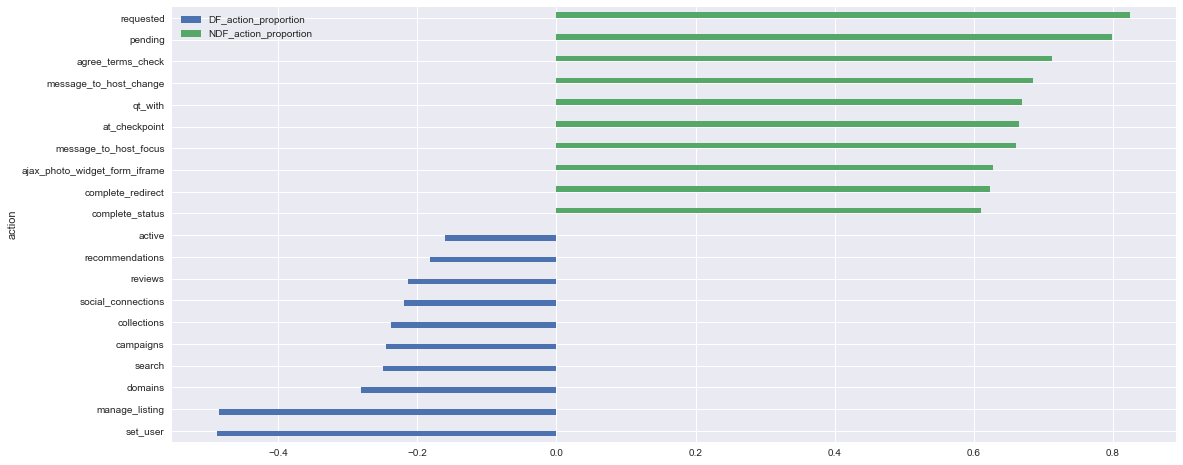

In [51]:
df_stats = action_stats[action_stats['count_df'] + action_stats['count_ndf'] > 500].sort_values(by='diff').head(10).reset_index()
ndf_stats = action_stats[action_stats['count_df'] + action_stats['count_ndf'] > 500].sort_values(by='diff').tail(10).sort_values(by='diff').reset_index()
stats = pd.DataFrame({
    'action': df_stats['action'].values.tolist() + ndf_stats['action'].values.tolist(),
    'DF_action_proportion': df_stats['diff'].values.tolist() +  [0 for _ in range(ndf_stats.shape[0])],
    'NDF_action_proportion': [0 for _ in range(df_stats.shape[0])] + ndf_stats['diff'].values.tolist(),
})
_ = stats.set_index('action').plot.barh(figsize=(18, 8))

In [10]:
sessions[sessions['action'] == 'reviews']

,user_id,action,action_type,action_detail,device_type,secs_elapsed,found_destination
2566,8s14bomsx5,reviews,-unknown-,-unknown-,iPhone,25.0,NDF
2575,8s14bomsx5,reviews,-unknown-,-unknown-,iPhone,171.0,NDF
2581,8s14bomsx5,reviews,-unknown-,-unknown-,iPhone,44.0,NDF
2588,8s14bomsx5,reviews,-unknown-,-unknown-,iPhone,342.0,NDF
2597,8s14bomsx5,reviews,-unknown-,-unknown-,iPhone,101.0,NDF
...,...,...,...,...,...,...,...
5554391,04y8115avm,reviews,data,listing_reviews,iPad Tablet,9402.0,NDF
5554393,04y8115avm,reviews,data,listing_reviews,iPad Tablet,1337.0,NDF
5554398,04y8115avm,reviews,data,listing_reviews,iPad Tablet,141.0,NDF
5554402,04y8115avm,reviews,data,listing_reviews,iPad Tablet,56957.0,NDF
